## Peer-graded Assignment: Анализ данных в задаче кредитного скоринга

In [3]:
import numpy as np
import pandas as pd
import itertools

from scipy import stats
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### 1.Размер кредитного лимита (LIMIT_BAL). 

In [5]:
df = pd.read_csv('credit_card_default_analysis.csv')
df.shape

(30000, 25)

In [6]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


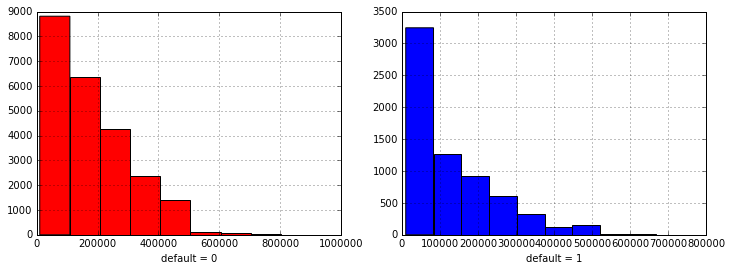

In [7]:
limitbal0 = df[df['default']  == 0].LIMIT_BAL.values
limitbal1 = df[df['default']  == 1].LIMIT_BAL.values
pylab.figure(figsize=(12,4))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(limitbal0, color = 'r')
pylab.xlabel('default = 0')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(limitbal1, color = 'b')
pylab.xlabel('default = 1')

pylab.show()

Основная доля невозвращенных кредитов приходится на малые кредитные лимиты (до 100000 у.е.)

В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: 

<b> a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки 

In [22]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

np.random.seed(0)

limitbal0_median_scores = map(np.median, get_bootstrap_samples(limitbal0, 1000))
limitbal1_median_scores = map(np.median, get_bootstrap_samples(limitbal1, 1000))

print "95% доверительный интервал для медины кредитного лимита, вернувших кредит:",  stat_intervals(limitbal0_median_scores, 0.05)
print "95% доверительный интервал для медины кредитного лимита, не вернувших кредит:",  stat_intervals(limitbal1_median_scores, 0.05)

95% доверительный интервал для медины кредитного лимита, вернувших кредит: [ 150000.  150000.]
95% доверительный интервал для медины кредитного лимита, не вернувших кредит: [ 80000.  90000.]


Доверительные интервалы для медианных оценок значений кредитного лимита не пересекаются. 

<b> b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

<b> Проверим перестановочным критерием

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [27]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = range(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

In [29]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)
    
print "p-value: %f" % permutation_test(limitbal0, limitbal1, max_permutations = 2000)

p-value: 0.000500


p-value = 0.0005. Гипотеза о равенстве средних отвергается в пользу двусторонней альтернативы на уровнем значимости 0.05.

Люди с меньшим кредитным лимитом более склонны не отдавать кредиты. Разница в медианных значениях практически в два раза, что подтверждает и практическую значимость

### 2.Пол (SEX) 

Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

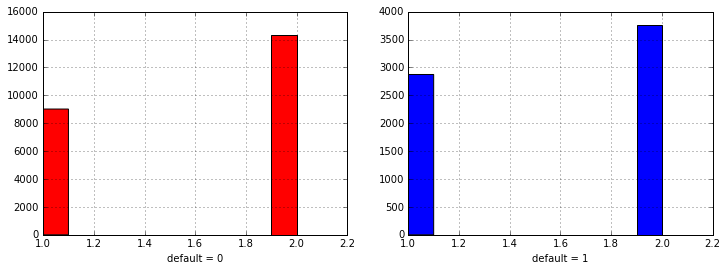

In [6]:
sex_default0 = df[df['default']  == 0].SEX
sex_default1 = df[df['default']  == 1].SEX
pylab.figure(figsize=(12,4))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(sex_default0, color = 'r')
pylab.xlabel('default = 0')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(sex_default1, color = 'b')
pylab.xlabel('default = 1')

pylab.show()

Построим доверительный интервал для разности долей

In [18]:
sex_default0_bin = sex_default0.apply(lambda x : 1 if x == 2 else 0)
sex_default1_bin = sex_default1.apply(lambda x : 1 if x == 2 else 0)

In [11]:
import scipy

def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

print "confidence interval: [%f, %f]" % proportions_confint_diff_ind(sex_default0_bin, sex_default1_bin)

NameError: name 'sex_default0_bin' is not defined

0 не попадает в доверительный интервал, гипотеза о равен долей отвергается

Проверим также статистическую значимость с помощью z-критерия для долей в независимых выборках. Проверять будем против двусторонней альтернативы с уровнем значимости 0.05.

In [25]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [26]:
print 'p-value:',  proportions_diff_z_test(proportions_diff_z_stat_ind(sex_default0_bin, sex_default1_bin))

p-value: 4.47286652161e-12


Гипотеза о равенстве гендерного состава групп отверается. Однако доля женщин превышает всего на 3-6%, таким образом, не смотря на статистическую значимость, практическая значимость невысока.

### 3.Образование (EDUCATION)

Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборт, не отдаст долг ?

In [8]:
observed_frequences = []
for i in range(7):
    educ_arr = df[df['EDUCATION'] == i].default.values
    observed_frequences.append([len(educ_arr) - sum(educ_arr), sum(educ_arr)])
f_obs = np.array(observed_frequences)

In [9]:
print f_obs

[[   14     0]
 [ 8549  2036]
 [10700  3330]
 [ 3680  1237]
 [  116     7]
 [  262    18]
 [   43     8]]


Получим ожидаемые значения:

In [12]:
chi2, p, dof, ex = scipy.stats.chi2_contingency(f_obs)
print p
print ex

1.23326262454e-32
[[  1.09032000e+01   3.09680000e+00]
 [  8.24359800e+03   2.34140200e+03]
 [  1.09265640e+04   3.10343600e+03]
 [  3.82935960e+03   1.08764040e+03]
 [  9.57924000e+01   2.72076000e+01]
 [  2.18064000e+02   6.19360000e+01]
 [  3.97188000e+01   1.12812000e+01]]


Нулевая гипотеза об отсутсвии связи между столбцами и строками уверенно отвергается.

Разница ожидаемых и наблюдаемых значений

In [13]:
diff = f_obs - ex
print diff

[[   3.0968   -3.0968]
 [ 305.402  -305.402 ]
 [-226.564   226.564 ]
 [-149.3596  149.3596]
 [  20.2076  -20.2076]
 [  43.936   -43.936 ]
 [   3.2812   -3.2812]]


In [14]:
diff_scaled = [diff[i]/float(sum(f_obs[i[0],:])) for i in np.ndindex(diff.shape)]
diff_scaled = np.array(diff_scaled).reshape(7,2)
print diff_scaled

[[ 0.2212     -0.2212    ]
 [ 0.02885234 -0.02885234]
 [-0.01614854  0.01614854]
 [-0.03037616  0.03037616]
 [ 0.16428943 -0.16428943]
 [ 0.15691429 -0.15691429]
 [ 0.06433725 -0.06433725]]


Образование "выпускника школы"  является индикатором, что велика вероятность, что человек не отдаст долг, в то время как уровень "доктор" наоброт свидетельствует о высокой вероятности вернуть долг.

### Семейное положение (MARRIAGE)

Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

In [15]:
f_obs_mar = []
for i in range(4):
    mar_arr = df[df['MARRIAGE'] == i].default.values
    f_obs_mar.append([len(mar_arr) - sum(mar_arr), sum(mar_arr)])
f_obs_mar = np.array(f_obs_mar)

In [16]:
print f_obs_mar

[[   49     5]
 [10453  3206]
 [12623  3341]
 [  239    84]]


In [17]:
chi2, p, dof, f_exp_mar = scipy.stats.chi2_contingency(f_obs_mar)
print p
print f_exp_mar

8.82586245758e-08
[[  4.20552000e+01   1.19448000e+01]
 [  1.06376292e+04   3.02137080e+03]
 [  1.24327632e+04   3.53123680e+03]
 [  2.51552400e+02   7.14476000e+01]]


In [18]:
diff_marr = f_obs_mar - f_exp_mar
print diff_marr

[[   6.9448   -6.9448]
 [-184.6292  184.6292]
 [ 190.2368 -190.2368]
 [ -12.5524   12.5524]]


In [19]:
diff_scaled = [diff_marr[i]/float(sum(f_obs_mar[i[0],:])) for i in np.ndindex(diff_marr.shape)]
diff_scaled = np.array(diff_scaled).reshape(4,2)
print diff_scaled

[[ 0.12860741 -0.12860741]
 [-0.01351704  0.01351704]
 [ 0.01191661 -0.01191661]
 [-0.03886192  0.03886192]]


Нулевая гипотеза об отсутсвии связи между семейным положением и вероятности дефолта отвергается. 

Вычислим меру связи с помощью коэффицента V-Крамера.

In [20]:
print np.sqrt(chi2/len(df))

0.0344782036628


Не смотря на статистическую значимость, корреляция между возрастом и уолвнем дефолта незначительно. Нельзя сказать о практической значимости признака.

### Возраст (AGE)

Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: a) о равенстве медианных значений возрастов людей b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

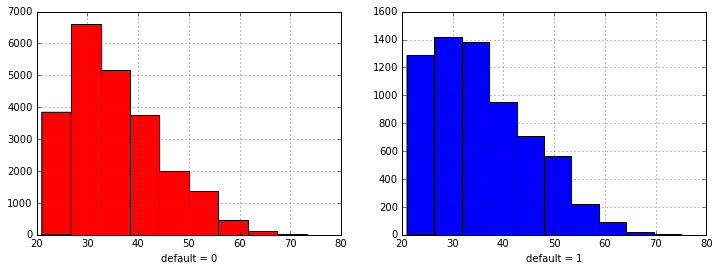

In [166]:
age0 = df[df['default']  == 0].AGE.values
age1 = df[df['default']  == 1].AGE.values
pylab.figure(figsize=(12,4))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(age0, color = 'r')
pylab.xlabel('default = 0')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(age1, color = 'b')
pylab.xlabel('default = 1')

pylab.show()

In [168]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

np.random.seed(0)

age0_median_scores = map(np.median, get_bootstrap_samples(age0, 1000))
age1_median_scores = map(np.median, get_bootstrap_samples(age1, 1000))

print "95% доверительный интервал для медины возраста, вернувших кредит:",  stat_intervals(age0_median_scores, 0.05)
print "95% доверительный интервал для медины возраста, не вернувших кредит:",  stat_intervals(age1_median_scores, 0.05)

95% доверительный интервал для медины возраста, вернувших кредит: [ 34.  34.]
95% доверительный интервал для медины возраста, не вернувших кредит: [ 34.  35.]


Доверительный интервалы пересекаются. Гипотеза о равенстве медианных значений не отвергается.

In [169]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = range(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)
    
print "p-value: %f" % permutation_test(age0, age1, max_permutations = 2000)

p-value: 0.014500


Нулевая гипотеза о равенстве средних против двусторонней альтернативы отвергается на уровне значимости 0.05.